In [ ]:
# Import packages
import os
import numpy as np
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image


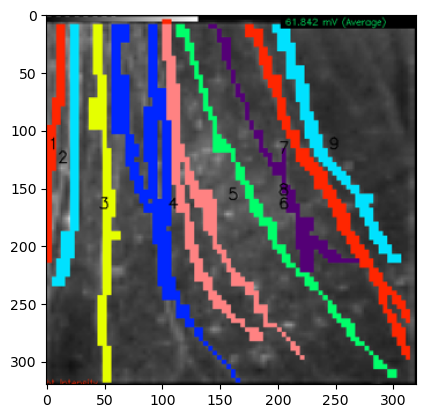

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


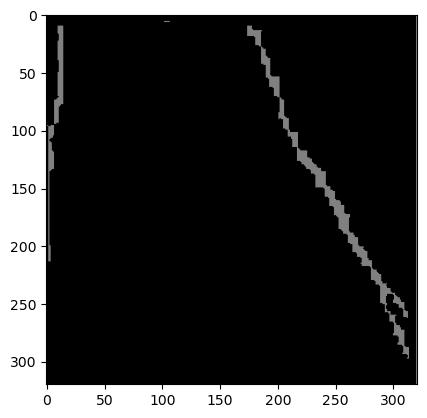

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


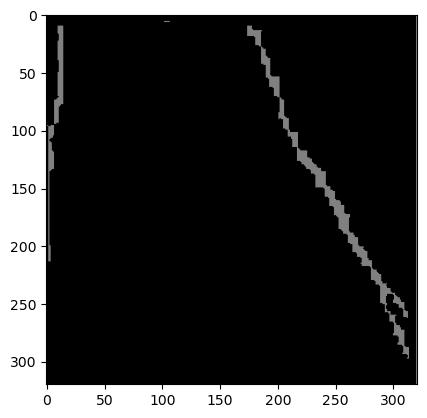

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


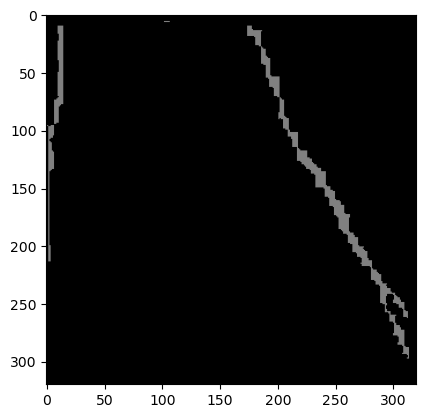

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


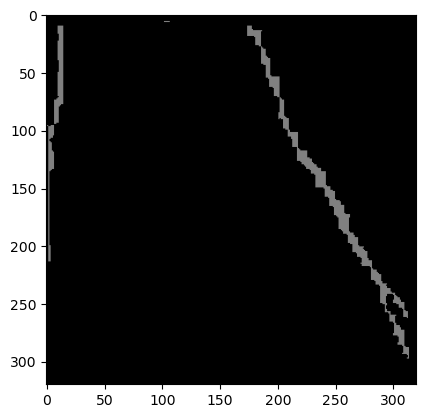

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


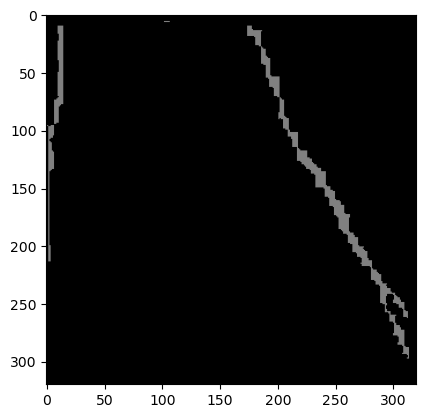

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


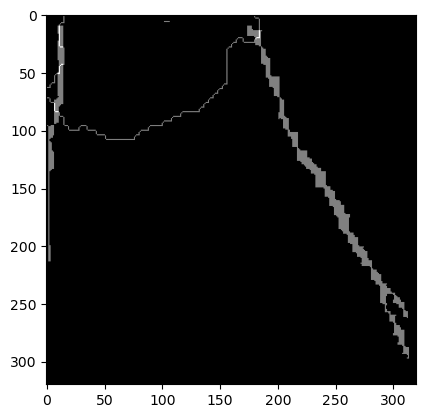

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


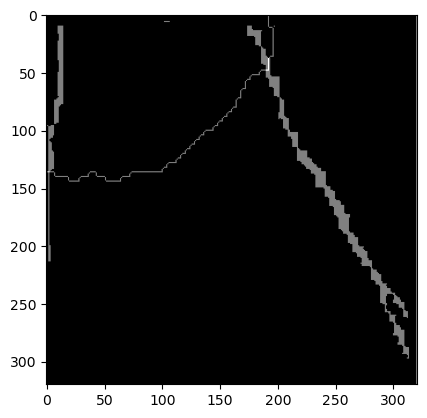

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


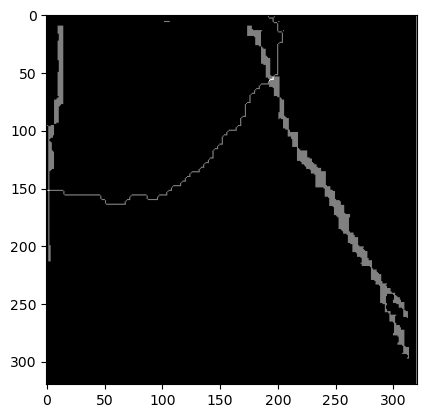

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


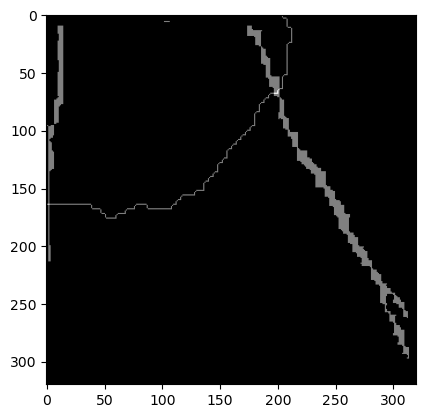

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


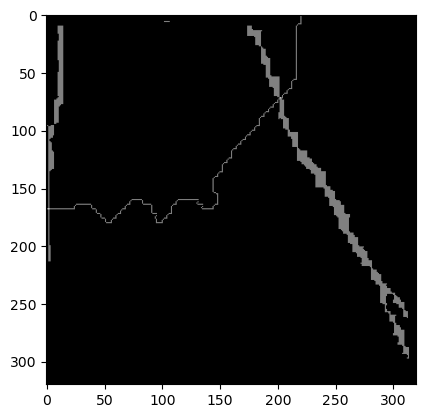

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


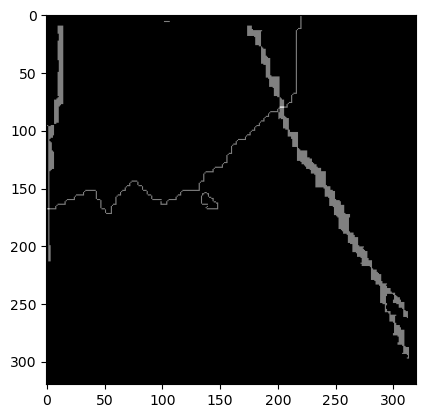

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


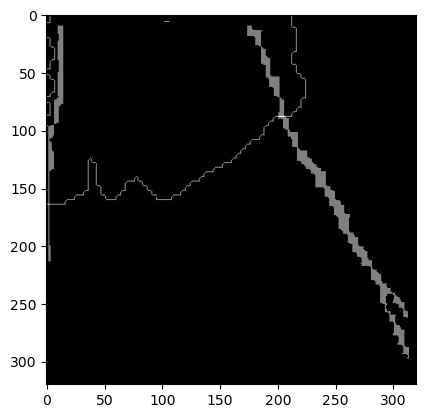

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


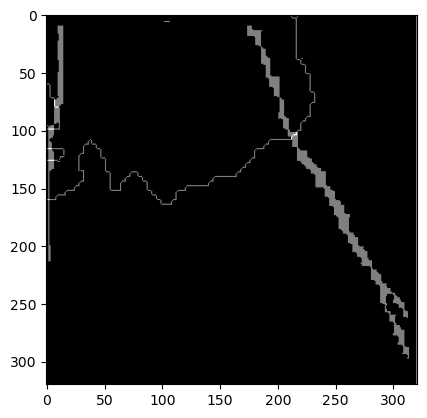

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


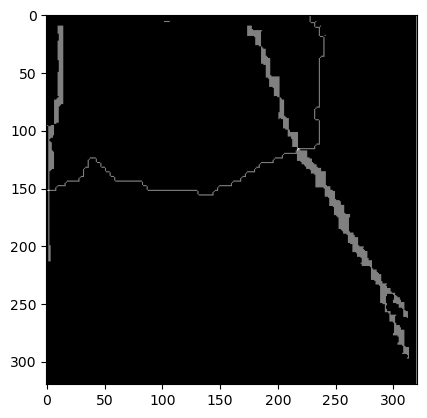

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


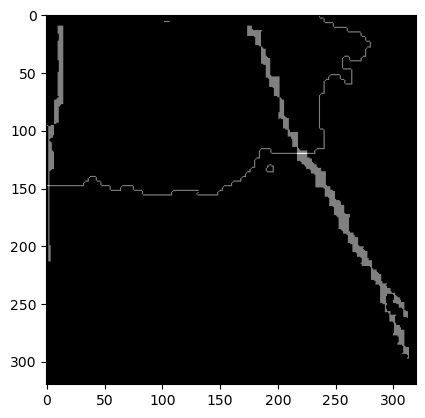

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


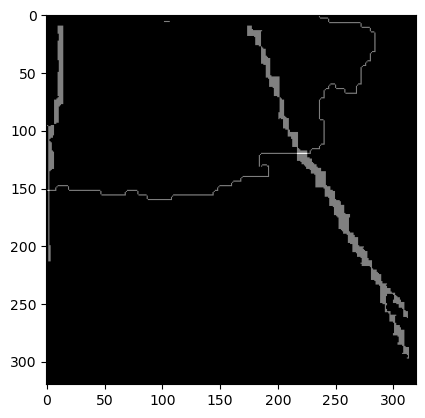

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


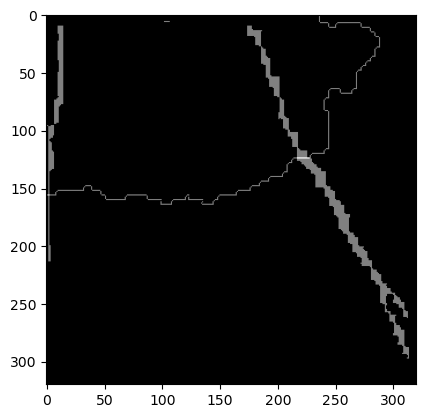

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


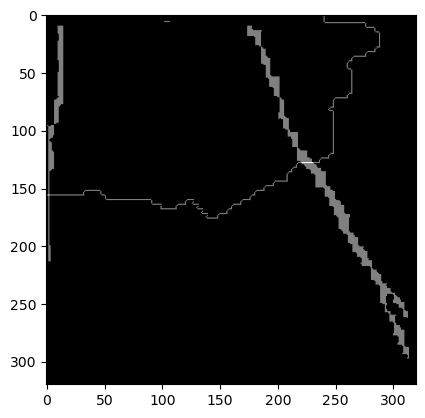

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


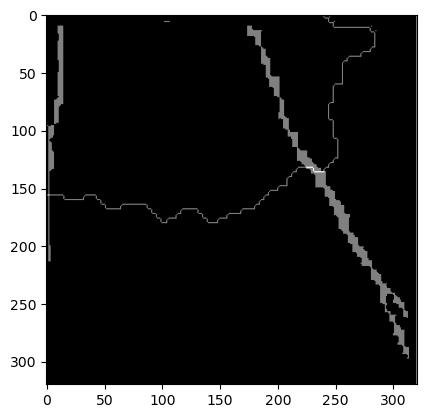

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


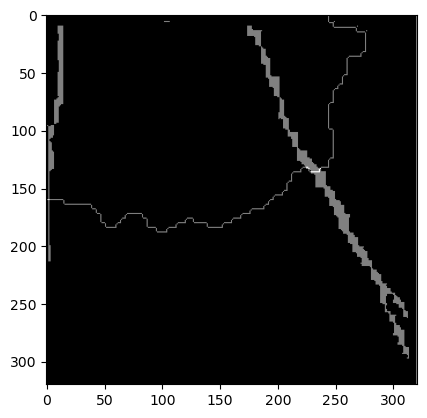

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


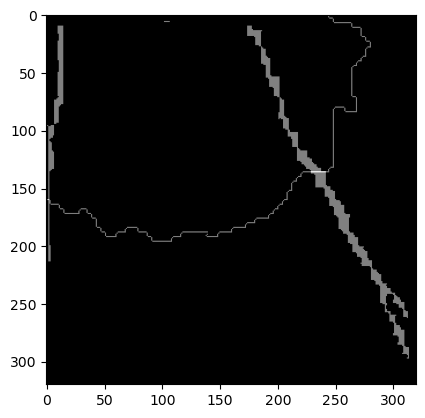

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


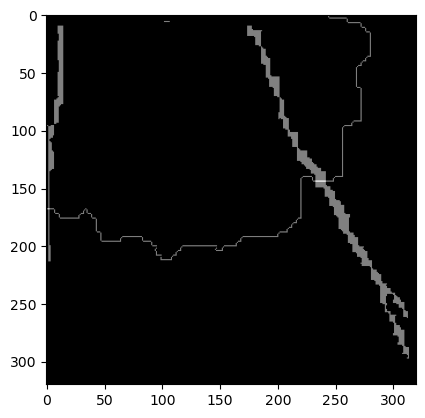

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


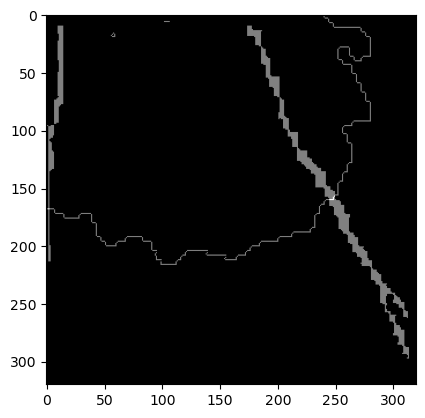

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


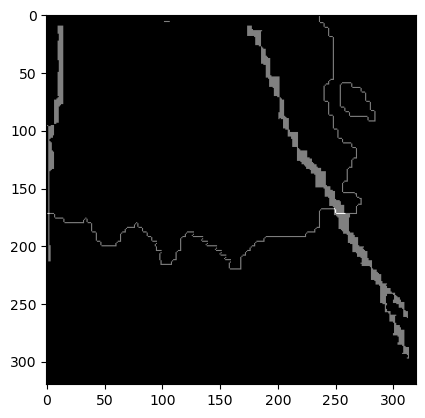

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


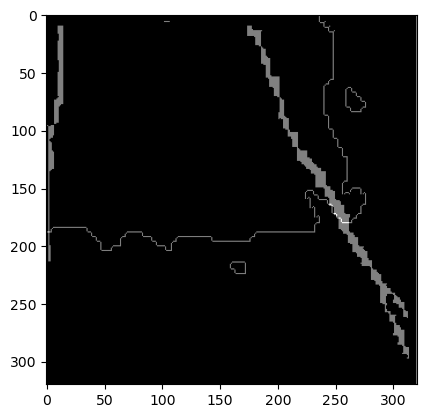

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


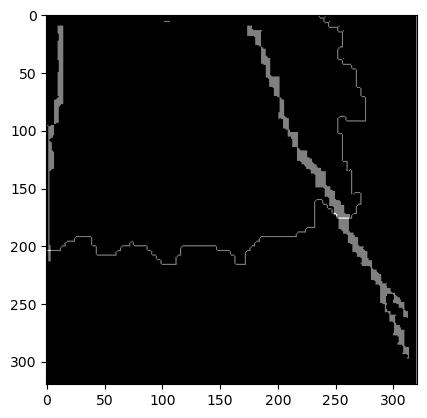

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


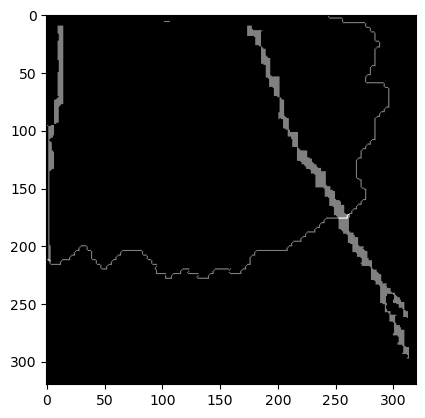

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


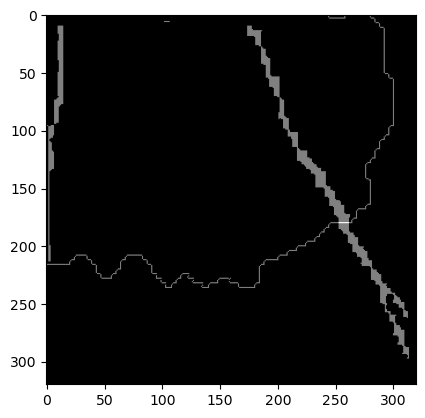

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


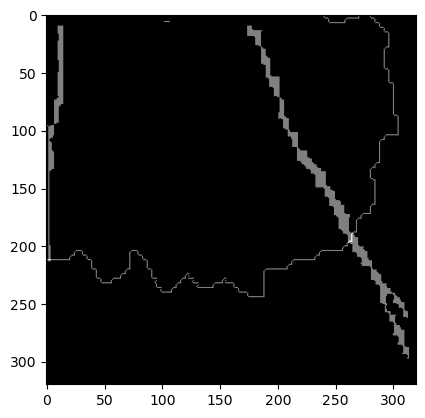

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


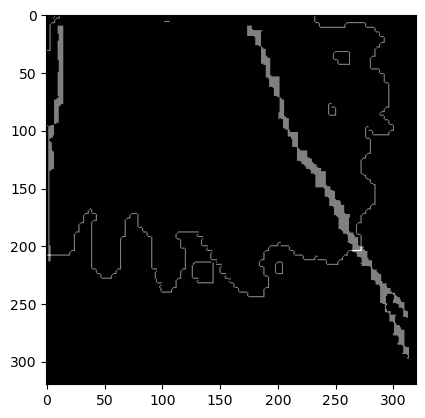

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


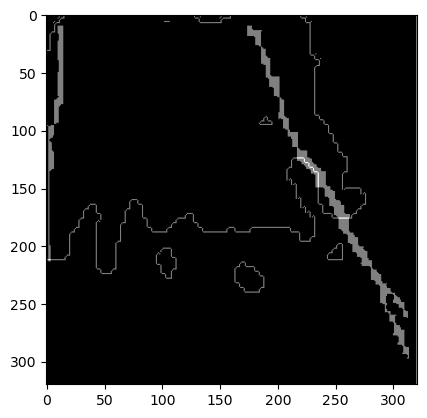

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


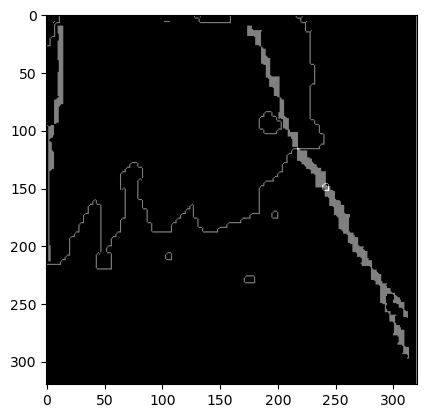

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


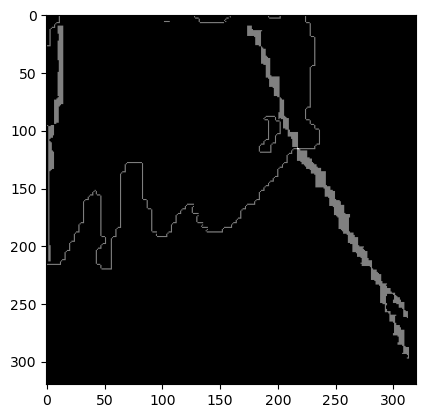

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


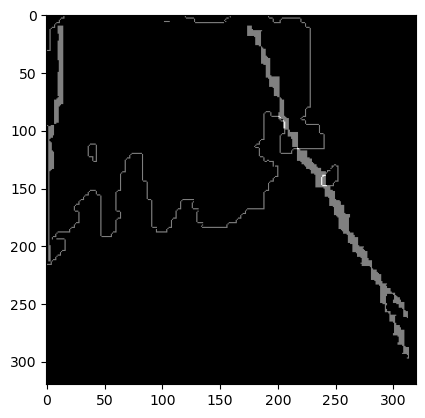

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


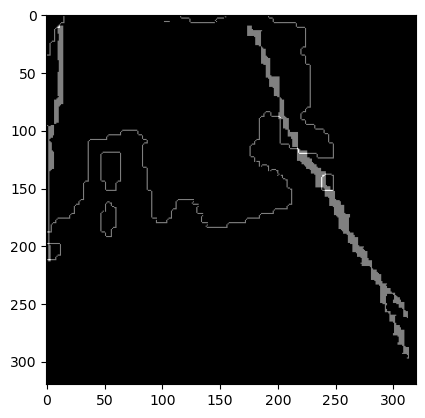

In [66]:
AorC = 'Cathodic'
data_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence\\data\\Fig5'

background_path = os.path.join(data_dir, f'{AorC}.tif')
image = Image.open(background_path).resize((320, 320))
backarr = np.array(image)

plt.imshow(backarr)
plt.show()

axon_colors = [(255, 38, 0, 255),
               (0, 225, 255, 255),
               (229, 255, 0, 255),
               (0, 38, 255, 255),
               (255, 130, 130, 255),
               (0, 255, 106, 255),
               (84, 0, 118, 255),
               (255, 38, 0, 255),
               (0, 225, 255, 255)]

axonarr = np.zeros((backarr.shape[0], backarr.shape[1], 3))
for i in range(backarr.shape[0]):
    for j in range(backarr.shape[1]):
        parirr = backarr[i, j]
        if tuple(parirr) == axon_colors[0]:
            axonarr[i, j] = np.array((255, 255, 255))

time_folder = os.path.join(data_dir, AorC)
for time_file in [f'{i}.tif' for i in range(1, len(os.listdir(time_folder))+1)]:
    image = Image.open(os.path.join(time_folder, time_file))
    imarr = np.array(image)
    binary = np.where(imarr > 0, 255, imarr)
    binary = np.uint8(binary)
    canny = cv.Canny(binary, 100, 200).astype(float)

    plt.imshow(axonarr, cmap='gray')
    plt.imshow(canny, alpha=0.5, cmap='gray')
    plt.show()

In [61]:
axonarr.shape

(320, 320, 3)

In [62]:
np.unique(axonarr)

array([  0., 255.])

In [67]:
canny.shape

(320, 320)

In [68]:
np.unique(canny)

array([  0., 255.])